# Training model
## Load from Gold layer

In [3]:
from datetime import datetime
from typing import List, Optional, Tuple

from pyspark.sql import SparkSession, DataFrame # type: ignore
from pyspark.sql.functions import col, to_timestamp, year, month # type: ignore
from functools import reduce
import os
import datetime

SOURCE_CATALOG = "datalake"
SOURCE_NAMESPACE = f"{SOURCE_CATALOG}.gold"
TARGET_CATALOG = "datalake"
TARGET_NAMESPACE = f"{TARGET_CATALOG}.gold"
FINANCIAL_COLUMNS = ["price"]
DATE_COLUMN = "Date"
BASE_PREDICT_PATH = '/src/data/predict'
BASE_FUTURE_PATH = '/src/data/future'
BASE_MODEL_PATH = '/src/model'
today = datetime.date.today()
today = today.strftime('%d_%m_%Y')

In [4]:
spark = (
        SparkSession.builder.appName("Test_read")
        .enableHiveSupport()
        .config("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED")
        .config("spark.sql.avro.datetimeRebaseModeInWrite", "CORRECTED")
        .getOrCreate()
    )
spark.sql(f"CREATE NAMESPACE IF NOT EXISTS {TARGET_NAMESPACE}")

DataFrame[]

## Read Gold Tables

In [5]:
# Read silver tables
try:
    merged_data = spark.table("datalake.gold.macro")
    
    print("Tables loaded successfully")
except Exception as e:
    print(f"Error loading silver tables: {e}")

Tables loaded successfully


In [6]:
# Display table schemas and sample data
print("Merge data schema:")
merged_data.printSchema()
merged_data.show(5)

Merge data schema:
root
 |-- date: timestamp (nullable = true)
 |-- gold: float (nullable = true)
 |-- oil: float (nullable = true)
 |-- us_dollar: float (nullable = true)
 |-- usd_vnd: float (nullable = true)
 |-- cpi: float (nullable = true)
 |-- inflation_rate: float (nullable = true)
 |-- interest_rate: float (nullable = true)
 |-- id: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

+-------------------+-----+-----+---------+-------+-----+--------------+-------------+----+----+-----+
|               date| gold|  oil|us_dollar|usd_vnd|  cpi|inflation_rate|interest_rate|  id|year|month|
+-------------------+-----+-----+---------+-------+-----+--------------+-------------+----+----+-----+
|2002-10-04 00:00:00|323.3|29.62|   108.02|15340.0|181.2|           0.2|         1.75|2830|2002|   10|
|2002-10-07 00:00:00|323.1|29.64|    107.9|15344.0|181.2|           0.2|         1.75|2833|2002|   10|
|2002-10-09 00:00:00|320.8|29.35|   107.26|1

In [7]:
merged_data.tail(5)

[Row(date=datetime.datetime(1997, 8, 20, 0, 0), gold=324.70001220703125, oil=20.059999465942383, us_dollar=100.44000244140625, usd_vnd=11690.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999961853027, id=959, year=1997, month=8),
 Row(date=datetime.datetime(1997, 8, 21, 0, 0), gold=326.6000061035156, oil=19.65999984741211, us_dollar=99.83999633789062, usd_vnd=11690.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999961853027, id=960, year=1997, month=8),
 Row(date=datetime.datetime(1997, 8, 23, 0, 0), gold=329.70001220703125, oil=19.700000762939453, us_dollar=98.9000015258789, usd_vnd=11690.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999961853027, id=962, year=1997, month=8),
 Row(date=datetime.datetime(1997, 8, 29, 0, 0), gold=327.3999938964844, oil=19.610000610351562, us_dollar=99.0, usd_vnd=11694.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999

In [8]:
merged_data.count()

11111

## Extract and Prepare Data

Extract Date and Price columns from each table and rename them appropriately

In [9]:
merged_data.orderBy('date').show(5)

+-------------------+-----+-----+---------+-------+-----+--------------+-------------+---+----+-----+
|               date| gold|  oil|us_dollar|usd_vnd|  cpi|inflation_rate|interest_rate| id|year|month|
+-------------------+-----+-----+---------+-------+-----+--------------+-------------+---+----+-----+
|1995-01-05 00:00:00|376.6|17.72|    89.04|11040.0|150.5|           0.3|         5.53|  1|1995|    1|
|1995-01-06 00:00:00|372.2|17.67|    89.71|11035.0|150.5|           0.3|         5.53|  2|1995|    1|
|1995-01-07 00:00:00|372.2|17.67|    89.71|11035.0|150.5|           0.3|         5.53|  3|1995|    1|
|1995-01-08 00:00:00|372.2|17.67|    89.71|11035.0|150.5|           0.3|         5.53|  4|1995|    1|
|1995-01-09 00:00:00|374.0| 17.4|    88.43|11035.0|150.5|           0.3|         5.53|  5|1995|    1|
+-------------------+-----+-----+---------+-------+-----+--------------+-------------+---+----+-----+
only showing top 5 rows



## Import libraries

In [10]:
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.notebook import tqdm_notebook
from typing import Union

In [12]:
print(merged_data.count())
print(merged_data.count() * 0.8)

11111
8888.800000000001


In [13]:
data = merged_data.orderBy('date').toPandas()
data.head()

,date,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate,id,year,month
0,1995-01-05,376.600006,17.719999,89.040001,11040.0,150.5,0.3,5.53,1,1995,1
1,1995-01-06,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53,2,1995,1
2,1995-01-07,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53,3,1995,1
3,1995-01-08,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53,4,1995,1
4,1995-01-09,374.000000,17.400000,88.430000,11035.0,150.5,0.3,5.53,5,1995,1


In [14]:
train_df = data[:8816].drop(columns=['date', 'year', 'month', 'id'])
test_df = data[8816:].drop(columns=['date', 'year', 'month', 'id'])
print(train_df.shape)
print(test_df.shape)

(8816, 7)
(2295, 7)


In [15]:
train_df.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate
0,376.600006,17.719999,89.040001,11040.0,150.5,0.3,5.53
1,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53
2,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53
3,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53
4,374.000000,17.400000,88.430000,11035.0,150.5,0.3,5.53


In [16]:
test_df.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate
8816,1329.699951,57.750000,96.366997,23209.0,253.319,0.3,2.4
8817,1326.500000,55.919998,96.271004,23216.0,253.319,0.3,2.4
8818,1325.300049,55.970001,95.864998,23200.0,253.319,0.3,2.4
8819,1321.199951,57.369999,96.038002,23199.0,253.319,0.3,2.4
8820,1316.099976,57.610001,96.042999,23199.0,253.319,0.3,2.4


## Scale data

In [17]:
scaled_train = train_df.copy()
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(scaled_train[i].values.reshape(-1,1))
    s_s = np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    scaled_train[i]=s_s
    
scaled_test = test_df.copy()
for i in test_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(scaled_test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    scaled_test[i]=s_s

## Testing data

In [18]:
def ADF_test(data):
    statistic = []
    p_value = []
    for col in data.columns:
        ad_fuller_result = adfuller(data[col])
        statistic.append(ad_fuller_result[0])
        p_value.append(round(ad_fuller_result[1], 5))

    ADF_res = pd.DataFrame({'Statistic': statistic, 'P-value': p_value}, index=data.columns)
    return ADF_res

In [19]:
ADF_test(scaled_train)

,Statistic,P-value
gold,-0.656158,0.85778
oil,-1.848371,0.35672
us_dollar,-1.612779,0.47652
usd_vnd,-0.407977,0.90876
cpi,-0.325862,0.92176
inflation_rate,-9.508917,0.00000
interest_rate,-1.885919,0.33871


In [20]:
def difference(dataset, order=1):
    return dataset.diff(periods=order).dropna()

train_diff = difference(scaled_train, order=1)
test_diff = difference(scaled_test, order=1)

In [21]:
ADF_test(train_diff)

,Statistic,P-value
gold,-24.578296,0.0
oil,-30.574214,0.0
us_dollar,-48.045162,0.0
usd_vnd,-22.855106,0.0
cpi,-10.402411,0.0
inflation_rate,-19.538415,0.0
interest_rate,-8.151295,0.0


## Finding optimize p

In [22]:
def optimize_VAR(endog: Union[pd.DataFrame, list]) -> pd.DataFrame:
    results = []

    for p in tqdm_notebook(range(1, 30)):
        try:
            model = VAR(endog)
            fitted_model = model.fit(maxlags=p, ic=None)
            aic = fitted_model.aic
            results.append([p, aic])
        except Exception as e:
            print(f"Error at lag {p}: {e}")
            continue

    result_df = pd.DataFrame(results, columns=['p', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [23]:
result_df = optimize_VAR(train_diff)
result_df.head()

  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be 

,p,AIC
0,2,-65.053503
1,1,-65.053428
2,7,-65.052292
3,8,-65.052138
4,6,-65.051020


In [24]:
def granger_causality_matrix(data, max_lag):
    variables = data.columns
    df = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            test_result = grangercausalitytests(data[[var1, var2]], max_lag, verbose=False)
            p_values = [round(test[0]['ssr_ftest'][1], 4) for test in test_result.values()]
            min_p_value = np.min(p_values)
            df.loc[var1, var2] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [25]:
p = result_df.iloc[0, 0]
no_columns = len(train_diff.columns)
granger_causality_matrix(train_diff, p)

,gold_x,oil_x,us_dollar_x,usd_vnd_x,cpi_x,inflation_rate_x,interest_rate_x
gold_y,1.0,0.0042,0.0,0.6931,0.0083,0.012,0.0688
oil_y,0.0006,1.0,0.2875,0.0109,0.0003,0.0,0.6043
us_dollar_y,0.0228,0.071,1.0,0.1434,0.0637,0.0144,0.3848
usd_vnd_y,0.7513,0.0289,0.0351,1.0,0.561,0.7733,0.6696
cpi_y,0.024,0.0108,0.0001,0.4277,1.0,0.652,0.8173
inflation_rate_y,0.0608,0.0286,0.0088,0.8434,1.0,1.0,1.0
interest_rate_y,0.2455,0.0017,0.0233,0.6778,0.9083,0.9989,1.0


# VARNN
## Split data

In [26]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.losses import MeanSquaredError, Huber
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

import torch
from torch import nn, optim

2025-06-09 12:41:06.016609: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 12:41:06.032048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749472866.049506   15877 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749472866.055685   15877 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749472866.071503   15877 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [27]:
strategy = tf.distribute.MirroredStrategy()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-06-09 12:41:10.987643: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [28]:
def to_sequences_multivariate(dataset, p):
    x = []
    y = []
    for i in range(p, len(dataset)):
        x.append(dataset.iloc[i - p:i, 0:dataset.shape[1]])
        y.append(dataset.iloc[i:i + 1, 0:dataset.shape[1]])
    x = np.array(x)
    y = np.array(y)
    return x,y.reshape(y.shape[0], y.shape[2])

In [29]:
trainX, trainY = to_sequences_multivariate(train_diff, p)
testX, testY = to_sequences_multivariate(test_diff, p)

## Define model

In [30]:
var_model = VAR(train_diff)
var_results = var_model.fit(p)
var_coefficients = var_results.params

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [31]:
class VARNN(tf.keras.Model):
    def __init__(self, var_weights, var_bias, hidden_units):
        super(VARNN, self).__init__()
        self.ffnn_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(p, no_columns)),  
            tf.keras.layers.Dense(hidden_units, activation='sigmoid')
        ])
        self.var_weights = tf.cast(var_weights, tf.float32)
        self.var_bias = tf.cast(var_bias, tf.float32)
        self.hidden_units = hidden_units

    def call(self, inputs):
        ffnn_output = self.ffnn_model(inputs)
        ffnn_output = tf.reshape(ffnn_output, [-1, self.hidden_units])
        var_output = tf.matmul(ffnn_output, self.var_weights) + self.var_bias
        return var_output

In [32]:
var_bias = var_coefficients.loc['const'].values
var_weights = var_coefficients.drop('const').values

In [33]:
VARNN_model = VARNN(var_weights, var_bias, no_columns * p)

# Compile the model
VARNN_model.compile(optimizer='adam', loss='mse')

# Add EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=10,              # Number of epochs with no improvement after which training stops
    restore_best_weights=True # Restore the weights from the epoch with the best val_loss
)

In [34]:
start = time.time()
history = VARNN_model.fit(
    trainX, trainY,
    verbose=0,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)
end = time.time()

In [35]:
print(end-start)

50.53530693054199


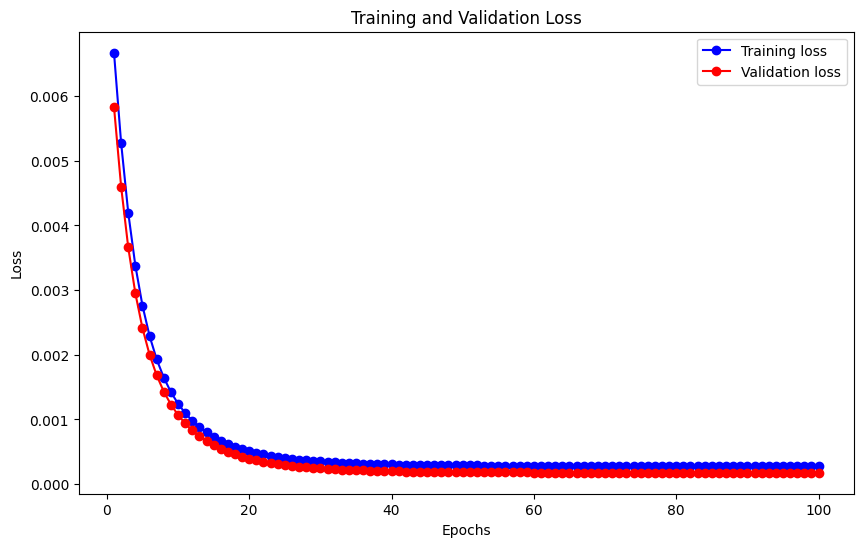

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# Get predictions
pred_VARNN = VARNN_model.predict(testX)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [38]:
def reverse_difference(original_data, differenced_data, order=1):
    reversed_data = []
    last_original_value = original_data.iloc[-len(differenced_data) - order:-order].values
    for i in range(len(differenced_data)):
        restored = differenced_data[i] + last_original_value[i]
        reversed_data.append(restored)
    return np.array(reversed_data)

In [39]:
# Reverse the differencing
last_test_values = scaled_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_VARNN_original = reverse_difference(last_test_values, pred_VARNN)

## Model Evaluation
### Scaled data

In [40]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_VARNN_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_VARNN_original)}')

MSE for gold: 0.0004730648943223059
MSE for oil: 0.0004942334489896894
MSE for us_dollar: 0.00022591515153180808
MSE for usd_vnd: 2.5285144147346728e-05
MSE for cpi: 1.8947437638416886e-05
MSE for inflation_rate: 0.0010635604849085212
MSE for interest_rate: 0.00016143987886607647
MSE total: 0.000351777853211388


In [41]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(testY_original[:, i], pred_VARNN_original[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(testY_original, pred_VARNN_original))
print(f'RMSE total: {total_rmse}')

RMSE for gold: 0.021750055041822446
RMSE for oil: 0.022231361833897834
RMSE for us_dollar: 0.0150304740953773
RMSE for usd_vnd: 0.005028433567956002
RMSE for cpi: 0.004352865451448837
RMSE for inflation_rate: 0.032612275064897285
RMSE for interest_rate: 0.012705899372577939
RMSE total: 0.018755741873127493


In [42]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_VARNN_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_VARNN_original)}')

MAE for gold: 0.012602884322404861
MAE for oil: 0.012967754155397415
MAE for us_dollar: 0.009623809717595577
MAE for usd_vnd: 0.002351013943552971
MAE for cpi: 0.0006992080016061664
MAE for inflation_rate: 0.0045666261576116085
MAE for interest_rate: 0.0014395695179700851
MAE total: 0.006321555469185114


### Original data

In [43]:
def unscale(data):
    temp = data.copy()
    for index, i in enumerate(train_df.columns):
        scaler = scalers['scaler_' + i]
        temp[:, index] = scaler.inverse_transform(np.reshape(data[:, index], (-1, 1))).flatten()
    return temp

In [44]:
unscaled_VARNN = unscale(pred_VARNN_original)
originY = unscale(testY_original)

In [45]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_VARNN)}')

MSE for gold: 317.3135986328125
MSE for oil: 2.2375288009643555
MSE for us_dollar: 0.1406666487455368
MSE for usd_vnd: 965.7011108398438
MSE for cpi: 0.0500769317150116
MSE for inflation_rate: 0.002722714329138398
MSE for interest_rate: 0.0016895044827833772
MSE total: 183.63540649414062


In [46]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(originY[:, i], unscaled_VARNN[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(originY, unscaled_VARNN))
print(f'RMSE total: {total_rmse}')

RMSE for gold: 17.813298364783893
RMSE for oil: 1.4958371572348226
RMSE for us_dollar: 0.3750555275496374
RMSE for usd_vnd: 31.07573186330201
RMSE for cpi: 0.2237787561745118
RMSE for inflation_rate: 0.05217963519552813
RMSE for interest_rate: 0.04110358235948999
RMSE total: 13.55121420737421


In [47]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_VARNN)}')

MAE for gold: 10.321767807006836
MAE for oil: 0.8725352883338928
MAE for us_dollar: 0.24014313519001007
MAE for usd_vnd: 14.529279708862305
MAE for cpi: 0.03594690561294556
MAE for inflation_rate: 0.007306601386517286
MAE for interest_rate: 0.004657040815800428
MAE total: 3.7159488201141357


In [43]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_VARNN)}')

MSE for gold: 253.48341369628906
MSE for oil: 2.2718677520751953
MSE for us_dollar: 0.13578380644321442
MSE for usd_vnd: 915.6316528320312
MSE for cpi: 0.05214967578649521
MSE for inflation_rate: 0.002835234859958291
MSE for interest_rate: 0.0017592895310372114
MSE total: 167.36862182617188


In [44]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(originY[:, i], unscaled_VARNN[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(originY, unscaled_VARNN))
print(f'RMSE total: {total_rmse}')

RMSE for gold: 15.921162448021471
RMSE for oil: 1.5072716251808085
RMSE for us_dollar: 0.3684885431641185
RMSE for usd_vnd: 30.259406022459054
RMSE for cpi: 0.22836303507024777
RMSE for inflation_rate: 0.05324692347881041
RMSE for interest_rate: 0.04194388550238534
RMSE total: 12.937102528239153


In [45]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_VARNN)}')

MAE for gold: 9.568632125854492
MAE for oil: 0.8782365918159485
MAE for us_dollar: 0.23651152849197388
MAE for usd_vnd: 14.15924072265625
MAE for cpi: 0.037124697118997574
MAE for inflation_rate: 0.007541689556092024
MAE for interest_rate: 0.00476634968072176
MAE total: 3.5560076236724854


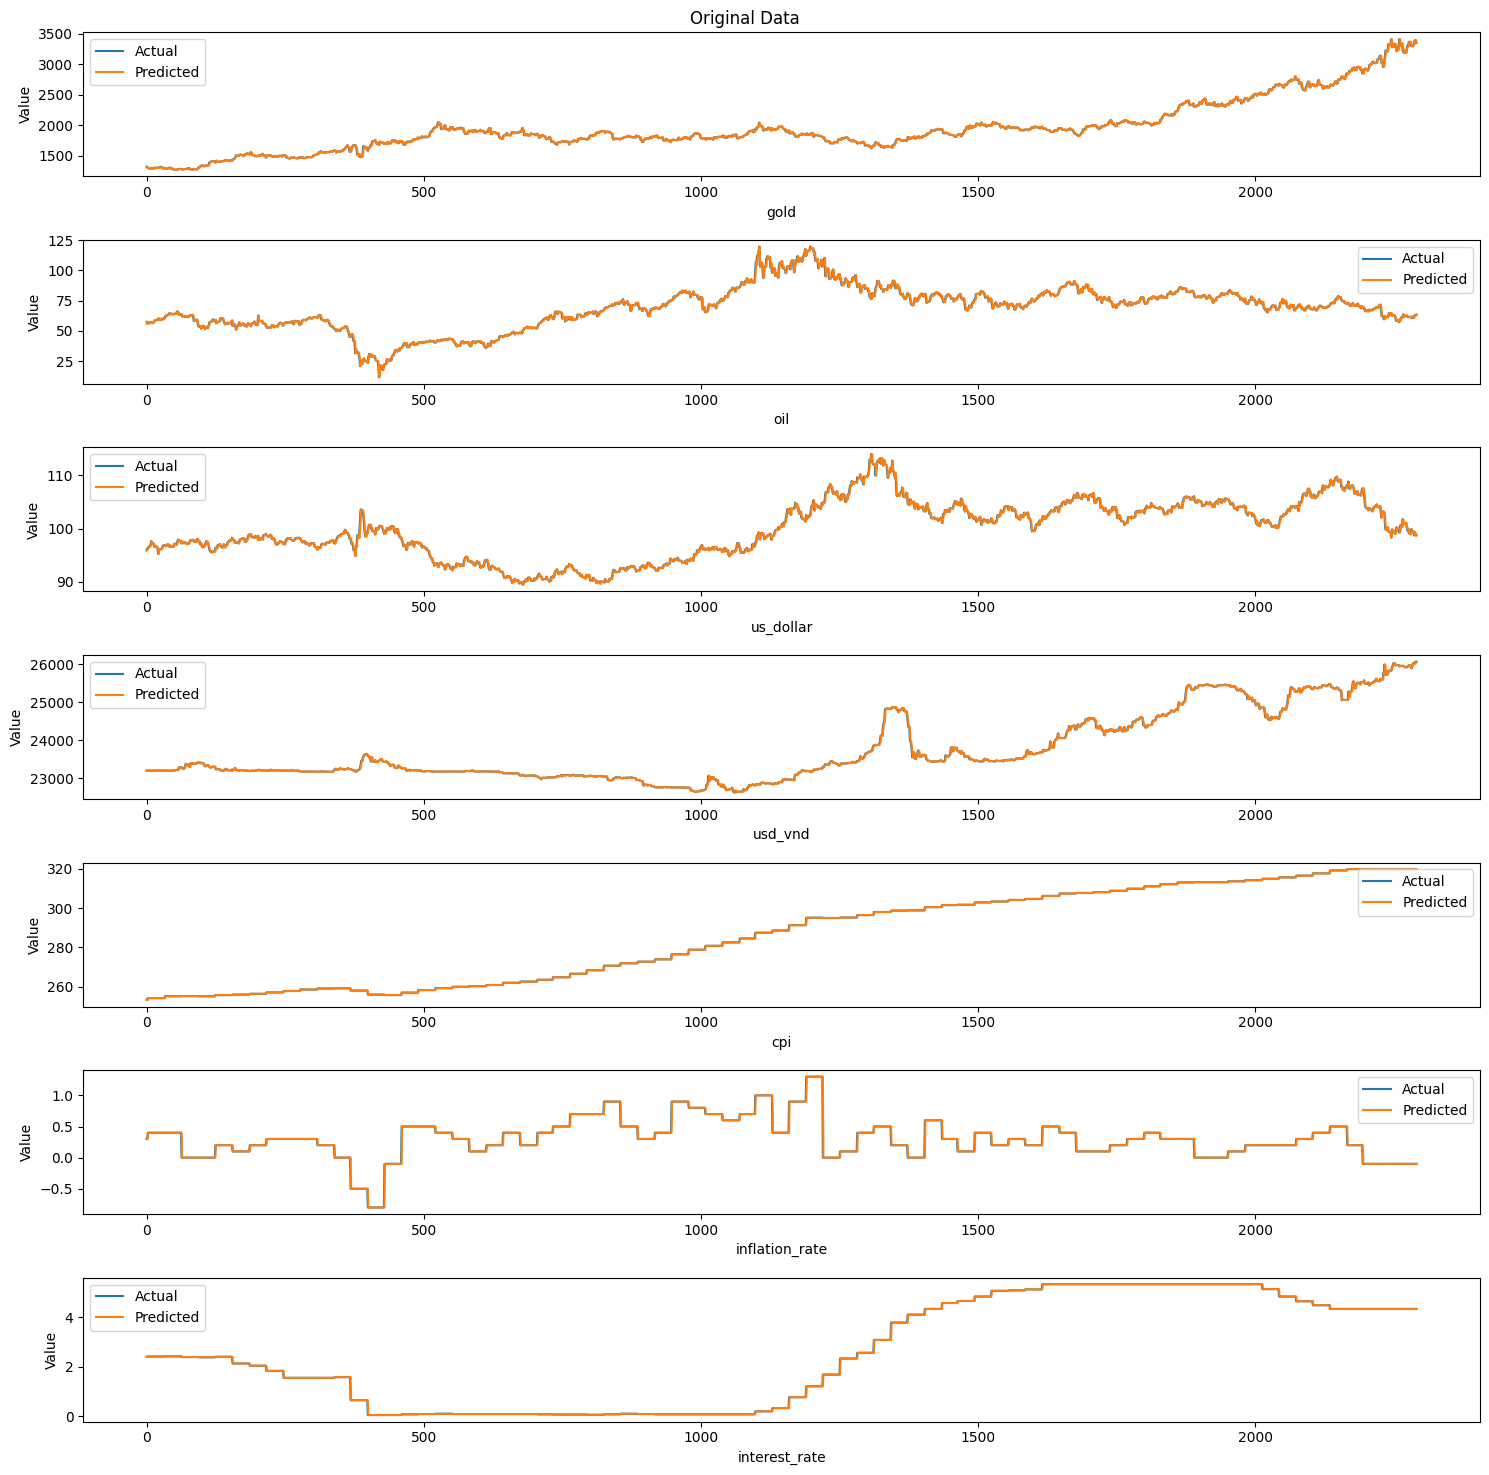

In [48]:
plt.figure(figsize=(15, 15))
for i in range(no_columns):
    plt.subplot(no_columns, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_VARNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

In [47]:
full_path = os.path.join(BASE_MODEL_PATH, 'varnn_macro_model.h5')

In [48]:
VARNN_model.save(full_path)

In [49]:
VAR_predict = pd.DataFrame(originY, columns=scaled_test.columns)
start_date = pd.to_datetime("03-03-2019", dayfirst=True)
VAR_predict["date"] = pd.date_range(start=start_date, periods=len(VAR_predict), freq='D')
VAR_predict.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate,date
0,1321.199951,57.369999,96.038002,23199.0,253.319000,0.3,2.40,2019-03-03
1,1316.099976,57.610001,96.042999,23199.0,253.319000,0.3,2.40,2019-03-04
2,1299.199951,56.189999,96.449997,23202.0,254.276993,0.4,2.41,2019-03-05
3,1299.199951,56.189999,96.449997,23202.0,254.276993,0.4,2.41,2019-03-06
4,1299.199951,56.189999,96.449997,23202.0,254.276993,0.4,2.41,2019-03-07


In [86]:
full_path = os.path.join(BASE_PREDICT_PATH, 'VARNN', f'macro_predict_{today}.csv')

In [87]:
VAR_predict.to_csv(full_path, index=False, float_format='%.5f')

## Predict future

In [52]:
def predict_future(model, last_window, p, num_steps):
    predictions = []
    current_window = last_window.copy()  # shape (p, num_vars)

    for _ in range(num_steps):
        input_seq = current_window[np.newaxis, ...]  # shape (1, p, num_vars)
        pred = model.predict(input_seq, verbose=0)[0]  # shape (num_vars,)
        predictions.append(pred)
        
        # Slide the window: drop the oldest, append the new prediction
        current_window = np.vstack([current_window[1:], pred])

    return np.array(predictions)

In [53]:
# Get the last `p` rows from training or testing data
last_window = test_diff.iloc[-p:].values  # shape: (p, num_vars)

# Predict p steps into the future
future_preds = predict_future(VARNN_model, last_window, p=p, num_steps=p)
future_preds = unscale(reverse_difference(last_test_values, future_preds))

print(future_preds.shape)

(2, 7)


In [54]:
future_VARNN = pd.DataFrame(future_preds, columns=scaled_test.columns)
start_date = pd.to_datetime("08-03-2025", dayfirst=True)
future_VARNN["date"] = pd.date_range(start=start_date, periods=len(future_VARNN), freq='D')
future_VARNN

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate,date
0,2925.784180,66.320419,104.218056,25488.425781,319.619202,-0.099134,4.330820,2025-03-08
1,2926.357422,66.374222,103.993340,25483.509766,319.618713,-0.099256,4.330737,2025-03-09


In [88]:
full_path = os.path.join(BASE_FUTURE_PATH, 'VARNN', f'macro_future_{today}.csv')

In [89]:
future_VARNN.to_csv(full_path, index=False, float_format='%.5f')

# SrVAR
## Define model

In [57]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return h_n[-1] 

In [58]:
class StateRegularizedUnit(nn.Module):
    def __init__(self, hidden_dim, num_states, tau=1.0):
        super(StateRegularizedUnit, self).__init__()
        self.state_encodings = nn.Parameter(torch.randn(num_states, hidden_dim))
        self.tau = tau

    def forward(self, u_t):
        # Proximity scores
        proximity_scores = torch.matmul(u_t, self.state_encodings.T)
        alpha = torch.softmax(proximity_scores / self.tau, dim=-1) 

        h_t = torch.matmul(alpha, self.state_encodings)  

        # Tính entropy regularization
        entropy_reg = -torch.sum(alpha * torch.log(alpha + 1e-10), dim=-1).mean()

        return h_t, alpha, entropy_reg

In [59]:
class GraphGeneration(nn.Module):
    def __init__(self, hidden_dim, num_vars):
        super(GraphGeneration, self).__init__()
        self.g_a = nn.Linear(hidden_dim, num_vars * num_vars)
        self.g_d = nn.Linear(hidden_dim, num_vars)

    def forward(self, c_st):
        A_st = self.g_a(c_st).view(-1, num_vars, num_vars)

        D_st = torch.diag_embed(self.g_d(c_st))

        # Ràng buộc tính không chu kỳ (Acyclicity constraint)
        exp_A = torch.matrix_exp(A_st * A_st)  
        trace_exp_A = torch.sum(torch.diagonal(exp_A, dim1=-2, dim2=-1), dim=-1)
        acyclic_penalty = torch.mean(trace_exp_A - A_st.size(-1))

        return A_st, D_st, acyclic_penalty

In [60]:
class DynamicVAR(nn.Module):
    def __init__(self, num_vars):
        super(DynamicVAR, self).__init__()
        self.var_weights = nn.Parameter(torch.randn(num_vars, num_vars))

    def forward(self, x_t, A_st, D_st):
        batch_size = x_t.size(0)
        x_t = x_t.unsqueeze(-1)

        x_hat_A = torch.matmul(A_st, x_t).squeeze(-1)

        weighted_x_t = torch.matmul(self.var_weights, x_t.squeeze(-1).unsqueeze(-1)).squeeze(-1)
        x_hat_D = torch.matmul(D_st, weighted_x_t.unsqueeze(-1)).squeeze(-1)

        x_hat = x_hat_A + x_hat_D
        return x_hat

In [61]:
class SrVARModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_states, num_vars, tau=1.0):
        super(SrVARModel, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim)
        self.state_regularized_unit = StateRegularizedUnit(hidden_dim, num_states, tau)
        self.graph_generation = GraphGeneration(hidden_dim, num_vars)
        self.dynamic_var = DynamicVAR(num_vars)

    def forward(self, x):
        u_t = self.encoder(x)
        h_t, alpha, entropy_reg = self.state_regularized_unit(u_t)
        A_st, D_st, acyclic_penalty = self.graph_generation(h_t)
        x_hat = self.dynamic_var(x[:, -1, :], A_st, D_st)

        return x_hat, alpha, entropy_reg, acyclic_penalty

In [62]:
def train_srvarm(model, trainX, trainY, valX, valY, num_epochs=100, batch_size=32, lr=0.001, tau=1.0, verbose=0, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Lagrangian parameters
    rho = 1.0
    lagrangian_multiplier = 0.0
    max_rho = 10.0

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0

        for i in range(0, len(trainX), batch_size):
            batch_x = torch.tensor(trainX[i:i + batch_size], dtype=torch.float32)
            batch_y = torch.tensor(trainY[i:i + batch_size], dtype=torch.float32)

            x_hat, alpha, entropy_reg, acyclic_penalty = model(batch_x)

            loss = (
                mse_loss(x_hat, batch_y)
                + 0.01 * entropy_reg
                + rho / 2 * acyclic_penalty.pow(2).mean()
                + lagrangian_multiplier * acyclic_penalty.mean()
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

        train_avg_loss = train_epoch_loss / (len(trainX) / batch_size)
        train_loss_history.append(train_avg_loss)

        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for i in range(0, len(valX), batch_size):
                batch_val_x = torch.tensor(valX[i:i + batch_size], dtype=torch.float32)
                batch_val_y = torch.tensor(valY[i:i + batch_size], dtype=torch.float32)

                x_hat, alpha, entropy_reg, acyclic_penalty = model(batch_val_x)

                val_loss = mse_loss(x_hat, batch_val_y) + 0.01 * entropy_reg
                val_epoch_loss += val_loss.item()

        val_avg_loss = val_epoch_loss / (len(valX) / batch_size)
        val_loss_history.append(val_avg_loss)

        # Verbose output
        if verbose == 1:
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_avg_loss:.4f}, Val Loss: {val_avg_loss:.4f}")

        # Early stopping
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_loss_history, val_loss_history

In [63]:
from copy import deepcopy
# Split train into train/validation sets
Xtrain, valX, Ytrain, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

input_dim = trainX.shape[2]
hidden_dim = 64
num_vars = trainX.shape[2]

best_val_loss = float('inf')
best_num_states = None
best_model = None
best_train_loss = None

# Try models with different number of hidden states
for num_states in range(1, 6):
    model = SrVARModel(input_dim=input_dim, hidden_dim=hidden_dim, num_states=num_states, num_vars=num_vars)

    trained_model_SrVAR, train_loss_history_SrVAR, val_loss_history_SrVAR = train_srvarm(
        model,
        Xtrain,
        Ytrain,
        valX,
        valY,
        num_epochs=100,
        batch_size=32,
        lr=0.0001,
        tau=1.0,
        verbose=0,
        patience=10
    )

    final_val_loss = val_loss_history_SrVAR[-1]
    final_train_loss = train_loss_history_SrVAR[-1]

    print(f"num_states: {num_states}, train_loss: {final_train_loss:.4f}, val_loss: {final_val_loss:.4f}")

    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_num_states = num_states
        best_model = deepcopy(trained_model_SrVAR)
        best_train_loss = final_train_loss

print(f"\nBest model: num_states={best_num_states}, val_loss={best_val_loss:.4f}, train_loss={best_train_loss:.4f}")

num_states: 1, train_loss: 0.0002, val_loss: 0.0004
num_states: 2, train_loss: 0.0073, val_loss: 0.0074
num_states: 3, train_loss: 0.0002, val_loss: 0.0004
num_states: 4, train_loss: 0.0002, val_loss: 0.0004
num_states: 5, train_loss: 0.0002, val_loss: 0.0004

Best model: num_states=4, val_loss=0.0004, train_loss=0.0002


In [64]:
model_SrVAR = best_model

start = time.time()

trained_model_SrVAR, train_loss_history_SrVAR, val_loss_history_SrVAR = train_srvarm(
    model_SrVAR,
    trainX,
    trainY,
    valX,
    valY,
    num_epochs=100,
    batch_size=32,
    lr=0.0001,
    tau=1.0,
    verbose=1,
    patience=10  # Set patience for early stopping
)

end = time.time()

print(f"Training completed in {end - start:.2f} seconds")

Epoch 10/100, Train Loss: 0.0003, Val Loss: 0.0004
Early stopping triggered at epoch 11
Training completed in 23.57 seconds


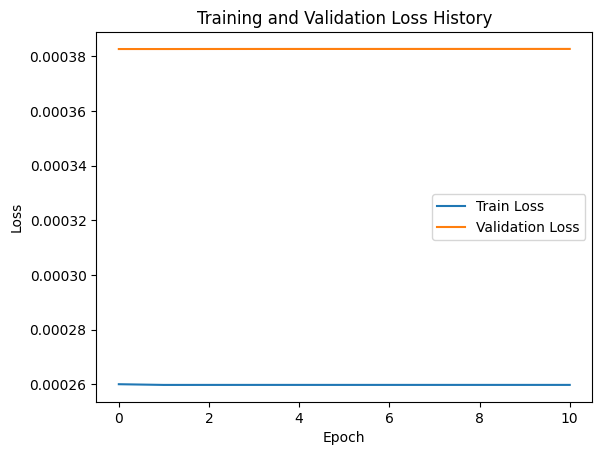

In [65]:
plt.plot(train_loss_history_SrVAR, label="Train Loss")
plt.plot(val_loss_history_SrVAR, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss History")
plt.legend()
plt.show()

In [66]:
model_SrVAR.eval() 
predictions_SrVAR = []
batch_size = 32

with torch.no_grad():
    for i in range(0, len(testX), batch_size):
        batch_x = torch.tensor(testX[i:i+batch_size], dtype=torch.float32)

        batch_pred, _, _, _ = model_SrVAR(batch_x)

        predictions_SrVAR.append(batch_pred.cpu().numpy())

predictions_SrVAR = np.concatenate(predictions_SrVAR, axis=0)

In [67]:
last_test_values = scaled_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_SrVAR_original = reverse_difference(last_test_values, predictions_SrVAR)

## Model Evaluation
### Scaled data

In [68]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_SrVAR_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_SrVAR_original)}')

MSE for gold: 0.0003797914832830429
MSE for oil: 0.0005017631920054555
MSE for us_dollar: 0.0002183045435231179
MSE for usd_vnd: 2.5654715500422753e-05
MSE for cpi: 1.9879678802681156e-05
MSE for inflation_rate: 0.0011060056276619434
MSE for interest_rate: 0.00016836487338878214
MSE total: 0.0003456799313426018


In [69]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(testY_original[:, i], pred_SrVAR_original[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(testY_original, pred_SrVAR_original))
print(f'RMSE total: {total_rmse}')

RMSE for gold: 0.019488239614779034
RMSE for oil: 0.02240007125000846
RMSE for us_dollar: 0.014775132605940221
RMSE for usd_vnd: 0.005065048420343359
RMSE for cpi: 0.004458663342604054
RMSE for inflation_rate: 0.03325666290628005
RMSE for interest_rate: 0.012975549059241469
RMSE total: 0.018592469748330957


In [70]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_SrVAR_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_SrVAR_original)}')

MAE for gold: 0.011731984093785286
MAE for oil: 0.013071213848888874
MAE for us_dollar: 0.009152386337518692
MAE for usd_vnd: 0.002431488363072276
MAE for cpi: 0.0007168757729232311
MAE for inflation_rate: 0.004636402707546949
MAE for interest_rate: 0.001425626571290195
MAE total: 0.006166569422930479


### Original data

In [71]:
unscaled_SrVAR = unscale(pred_SrVAR_original)
originY = unscale(testY_original)

In [72]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_SrVAR[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_SrVAR)}')

MSE for gold: 254.7493133544922
MSE for oil: 2.271618127822876
MSE for us_dollar: 0.13592781126499176
MSE for usd_vnd: 979.8155517578125
MSE for cpi: 0.05254073813557625
MSE for inflation_rate: 0.002831373829394579
MSE for interest_rate: 0.0017619759310036898
MSE total: 176.7184295654297


In [73]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(originY[:, i], unscaled_SrVAR[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(originY, unscaled_SrVAR))
print(f'RMSE total: {total_rmse}')

RMSE for gold: 15.960868189246229
RMSE for oil: 1.507188816247943
RMSE for us_dollar: 0.3686838907044784
RMSE for usd_vnd: 31.302005554881184
RMSE for cpi: 0.2292176654090523
RMSE for inflation_rate: 0.0532106552242554
RMSE for interest_rate: 0.04197589702440783
RMSE total: 13.293548418892138


In [74]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_SrVAR[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_SrVAR)}')

MAE for gold: 9.60849666595459
MAE for oil: 0.8794966340065002
MAE for us_dollar: 0.2283795177936554
MAE for usd_vnd: 15.026599884033203
MAE for cpi: 0.03685392066836357
MAE for inflation_rate: 0.007418243680149317
MAE for interest_rate: 0.00461190240457654
MAE total: 3.6845507621765137


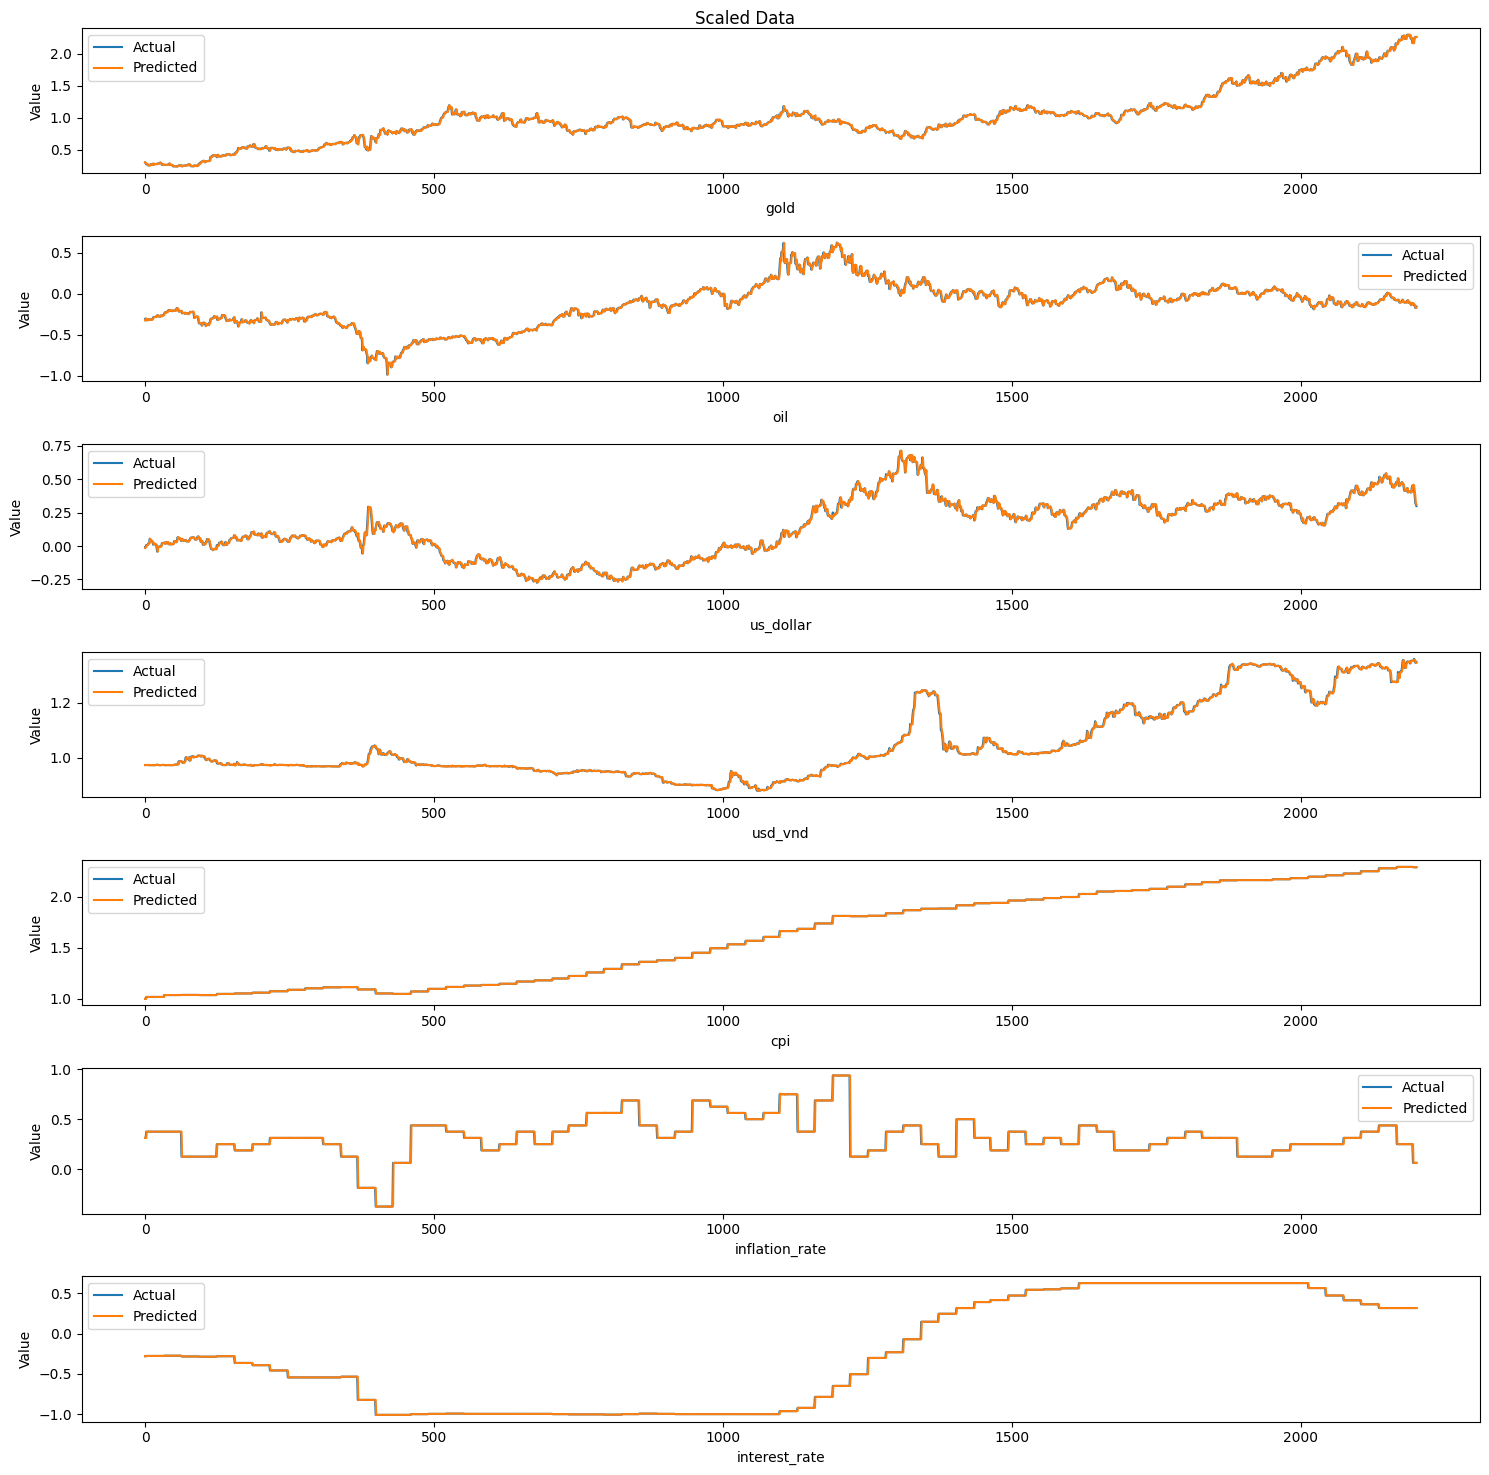

In [75]:
plt.figure(figsize=(15, 15))
for i in range(no_columns):
    plt.subplot(no_columns, 1, i+1)
    plt.plot(testY_original[:, i], label='Actual')
    plt.plot(pred_SrVAR_original[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

In [76]:
full_path = os.path.join(BASE_MODEL_PATH, "srvar_model_macro.pth")

In [77]:
torch.save(trained_model_SrVAR.state_dict(), full_path)

In [78]:
SrVAR_predict = pd.DataFrame(originY, columns=scaled_test.columns)
start_date = pd.to_datetime("03-03-2019", dayfirst=True)
SrVAR_predict["date"] = pd.date_range(start=start_date, periods=len(SrVAR_predict), freq='D')
SrVAR_predict.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate,date
0,1321.199951,57.369999,96.038002,23199.0,253.319000,0.3,2.40,2019-03-03
1,1316.099976,57.610001,96.042999,23199.0,253.319000,0.3,2.40,2019-03-04
2,1299.199951,56.189999,96.449997,23202.0,254.276993,0.4,2.41,2019-03-05
3,1299.199951,56.189999,96.449997,23202.0,254.276993,0.4,2.41,2019-03-06
4,1299.199951,56.189999,96.449997,23202.0,254.276993,0.4,2.41,2019-03-07


In [90]:
full_path = os.path.join(BASE_PREDICT_PATH, "SrVAR", f"macro_predict_{today}.csv")

In [91]:
SrVAR_predict.to_csv(full_path, index=False, float_format='%.5f')

## Predict Future

In [81]:
def srvar_predict_future(model, last_window, num_steps):
    model.eval()
    predictions = []

    # Ensure starting window shape is (1, p, num_vars)
    current_window = torch.tensor(last_window[np.newaxis, ...], dtype=torch.float32)

    with torch.no_grad():
        for _ in range(num_steps):
            pred, _, _, _ = model(current_window)     # shape: (1, num_vars)
            pred_np = pred.cpu().numpy()[0]           # shape: (num_vars,)
            predictions.append(pred_np)

            # Update window: remove first row, append prediction
            pred_tensor = pred.unsqueeze(1)           # shape: (1, 1, num_vars)
            current_window = torch.cat([current_window[:, 1:], pred_tensor], dim=1)  # Keep shape (1, p, num_vars)

    return np.array(predictions)

In [82]:
# Predict p steps into the future
future_preds_srvar = srvar_predict_future(model_SrVAR, last_window, num_steps=p)
future_preds_srvar = unscale(reverse_difference(last_test_values, future_preds_srvar))
print(future_preds_srvar.shape)

(2, 7)


In [83]:
future_SrVAR = pd.DataFrame(future_preds_srvar, columns=scaled_test.columns)
start_date = pd.to_datetime("08-03-2025", dayfirst=True)
future_SrVAR["date"] = pd.date_range(start=start_date, periods=len(future_SrVAR), freq='D')
future_SrVAR.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate,date
0,2926.650879,66.298141,104.264008,25486.589844,319.616638,-0.099336,4.329891,2025-03-08
1,2926.549805,66.361397,104.026154,25485.427734,319.614899,-0.099999,4.329964,2025-03-09


In [92]:
full_path = os.path.join(BASE_FUTURE_PATH, "SrVAR", f"macro_future_{today}.csv")

In [93]:
future_SrVAR.to_csv(full_path, index=False, float_format='%.5f')